# Proyek Akhir: Membuat Model Sistem Rekomendasi

# Import Libarary

In [248]:
import pandas as pd
import numpy as np
import ast
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate
from pathlib import Path
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Data Understanding

In [2]:
kdrama_df = pd.read_csv('https://raw.githubusercontent.com/sirly82/kdrama-recommendation/refs/heads/main/dataset/korean_drama.csv')
reviews_df = pd.read_csv('https://raw.githubusercontent.com/sirly82/kdrama-recommendation/refs/heads/main/dataset/reviews.csv')
genres_df = pd.read_csv('https://raw.githubusercontent.com/sirly82/kdrama-recommendation/refs/heads/main/scraping-data/kdrama_genres_platforms.csv')

# Load Dataset

In [3]:
kdrama_df.head()

,kdrama_id,drama_name,year,director,screenwriter,country,type,tot_eps,duration,start_dt,end_dt,aired_on,org_net,content_rt,synopsis,rank,pop
0,661d4193916c4e71a2c70473ab11e9e8,Sing My Crush,2023,['So Joon Moon'],NaN,South Korea,Drama,8,1500.0,"Aug 2, 2023","Aug 2, 2023",Wednesday,NaN,Not Yet Rated,Follow the story of acquaintances Ba Ram and H...,1484,2238
1,5ffcbeaa17114714af1959129984274c,D.P. Season 2,2023,NaN,['Kim Bo Tong'],South Korea,Drama,6,3000.0,"Jul 28, 2023","Jul 28, 2023",Friday,Netflix,15+ - Teens 15 or older,This unfolding story ensues when military dese...,164,1084
2,65075cb9c1a54be4a441cee6f16c9fdf,Shadow Detective Season 2,2023,['Han Dong Hwa'],"['Song Jung Woo', 'Hwang Seol Hun']",South Korea,Drama,8,3300.0,2023-07-05,2023-07-26,Wednesday,Disney+ Hulu,15+ - Teens 15 or older,Unfolds the ultimate counterattack of veteran ...,2443,6915
3,df0f0ac4b3ff4b15afa26f5a7a53a328,To Be Honest,2023,NaN,NaN,South Korea,Drama,3,600.0,2023-06-30,2023-07-14,Friday,NaN,Not Yet Rated,Don't you have those days where the whole univ...,49895,99999
4,04c1fe41948e464fb440001831d74d41,Celebrity,2023,['Kim Chul Gyu'],['Kim Yi Young'],South Korea,Drama,12,2700.0,"Jun 30, 2023","Jun 30, 2023",Friday,Netflix,18+ Restricted (violence & profanity),Fame. Money. Power. One young woman fights to ...,826,547


In [4]:
reviews_df.head()

,user_id,title,story_score,acting_cast_score,music_score,rewatch_value_score,overall_score,review_text,ep_watched,n_helpful
0,c8ffdab3f2a338eeb54b265598dbbb55,Sing My Crush,9.0,9.0,10.0,9.0,9.0,the Best Song from my Crush This will now ran...,8 of 8 episodes seen,23
1,c8ffdab3f2a338eeb54b265598dbbb55,Happy Merry Ending,5.0,7.0,9.0,4.0,6.5,I'm Happy and Merry That it Ended Quickly The ...,8 of 8 episodes seen,31
2,c8ffdab3f2a338eeb54b265598dbbb55,Duty After School: Part 2,4.0,9.0,3.0,1.0,4.0,This PART 2 Should Never Have Happened If you...,4 of 4 episodes seen,121
3,c8ffdab3f2a338eeb54b265598dbbb55,Our Dating Sim,9.0,9.5,9.0,9.0,9.0,I want to play this dating sim! I want to pla...,8 of 8 episodes seen,79
4,c8ffdab3f2a338eeb54b265598dbbb55,The Director Who Buys Me Dinner,7.5,8.5,7.0,6.0,7.0,"Half-Cooked, Dont Eat A hard pass, unless som...",10 of 10 episodes seen,66


In [6]:
genres_df.head()

,title,genres,where_to_watch
0,Mad Dog,"Action, Thriller, Mystery","Apple TV, Netflix, Viki, Kocowa"
1,The Good Detective,"Action, Thriller, Mystery, Drama","Netflix, VIU Indonesia, Viki, Tubi"
2,Crash Course in Romance,"Thriller, Mystery, Comedy, Romance",Netflix
3,Amanza,"Adventure, Life, Fantasy, Melodrama","Kakao TV, Viki, Kocowa"
4,The Uncanny Counter Season 2: Counter Punch,"Action, Mystery, Comedy, Supernatural","TVING, Netflix"


In [238]:
print('Jumlah data korean drama: ', len(kdrama_df.kdrama_id.unique()))
print('Jumlah data reviews korean drama: ', len(reviews_df.user_id.unique()))
print('Jumlah data genres korean drama: ', len(genres_df))

Jumlah data korean drama:  1752
Jumlah data reviews korean drama:  4562
Jumlah data genres korean drama:  1868


# Univariate Exploratory Data Analysis

## kdrama dataset

In [9]:
kdrama_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   kdrama_id     1752 non-null   object 
 1   drama_name    1752 non-null   object 
 2   year          1752 non-null   int64  
 3   director      1036 non-null   object 
 4   screenwriter  959 non-null    object 
 5   country       1752 non-null   object 
 6   type          1752 non-null   object 
 7   tot_eps       1752 non-null   int64  
 8   duration      1728 non-null   float64
 9   start_dt      1752 non-null   object 
 10  end_dt        1752 non-null   object 
 11  aired_on      1520 non-null   object 
 12  org_net       1344 non-null   object 
 13  content_rt    1752 non-null   object 
 14  synopsis      1584 non-null   object 
 15  rank          1752 non-null   int64  
 16  pop           1752 non-null   int64  
dtypes: float64(1), int64(4), object(12)
memory usage: 232.8+ KB


In [10]:
print('Banyak data: ', len(kdrama_df.kdrama_id.unique()))
print('Judul Drama Korea: ', kdrama_df.drama_name.unique())

Banyak data:  1752
Judul Drama Korea:  ['Sing My Crush' 'D.P. Season 2' 'Shadow Detective Season 2' ...
 'Iron Lady Cha' 'The Family Is Coming' 'Crow Building']


## reviews dataset

In [11]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10625 entries, 0 to 10624
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              10625 non-null  object 
 1   title                10625 non-null  object 
 2   story_score          10625 non-null  float64
 3   acting_cast_score    10625 non-null  float64
 4   music_score          10625 non-null  float64
 5   rewatch_value_score  10625 non-null  float64
 6   overall_score        10625 non-null  float64
 7   review_text          10619 non-null  object 
 8   ep_watched           10625 non-null  object 
 9   n_helpful            10625 non-null  int64  
dtypes: float64(5), int64(1), object(4)
memory usage: 830.2+ KB


In [12]:
reviews_df.describe()

,story_score,acting_cast_score,music_score,rewatch_value_score,overall_score,n_helpful
count,10625.000000,10625.000000,10625.000000,10625.000000,10625.000000,10625.000000
mean,7.501459,8.442635,7.597271,6.170447,7.636988,15.553035
std,2.221619,1.750424,2.188483,3.086057,2.109013,31.726984
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,6.000000,8.000000,6.500000,4.000000,6.500000,2.000000
50%,8.000000,9.000000,8.000000,7.000000,8.000000,6.000000
75%,9.000000,10.000000,9.500000,9.000000,9.500000,15.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,551.000000


## genres dataset

In [15]:
genres_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1868 entries, 0 to 1867
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           1868 non-null   object
 1   genres          1861 non-null   object
 2   where_to_watch  1281 non-null   object
dtypes: object(3)
memory usage: 43.9+ KB


In [16]:
print('Banyak data: ', len(genres_df.title.unique()))
print('Genre Drama: ', genres_df.genres.unique())

Banyak data:  1867
Genre Drama:  ['Action, Thriller, Mystery' 'Action, Thriller, Mystery, Drama'
 'Thriller, Mystery, Comedy, Romance'
 'Adventure, Life, Fantasy, Melodrama'
 'Action, Mystery, Comedy, Supernatural' 'Comedy, Romance, Youth, Fantasy'
 'Comedy, Romance, Drama, Fantasy' 'Comedy, Romance, Drama, Sci-Fi'
 'Thriller, Romance, Drama, Melodrama'
 'Thriller, Mystery, Comedy, Fantasy' 'Thriller, Romance, Melodrama'
 'Thriller, Law, Crime, Medical' 'Comedy, Romance, Life, Melodrama'
 'Music, Romance' 'Action, Mystery, Comedy, Drama'
 'Action, Thriller, Mystery, Supernatural'
 'Psychological, Crime, Youth, Drama'
 'Mystery, Horror, Youth, Supernatural'
 'Thriller, Mystery, Romance, Melodrama'
 'Business, Comedy, Romance, Drama' 'Romance, Youth, Drama, Fantasy'
 'Life, Drama' 'Romance, Life, Drama, Medical' 'Action, Youth, Drama'
 'Action, Historical, Romance, Fantasy'
 'Thriller, Romance, Crime, Melodrama' 'Comedy, Romance, Life, Youth'
 'Comedy, Life, Drama, Medical' 'Psychologica

In [17]:
print('Platforms Drama: ', genres_df.where_to_watch.unique())

Platforms Drama:  ['Apple TV, Netflix, Viki, Kocowa' 'Netflix, VIU Indonesia, Viki, Tubi'
 'Netflix' 'Kakao TV, Viki, Kocowa' 'TVING, Netflix'
 'WeTV, Viki, iQIYI, Kocowa'
 'Apple TV, Netflix, WeTV, Viki, iQIYI, Hulu, VIU Indonesia, SBS VOD'
 'Apple TV, Netflix, WeTV, Viki, HBO Max, Kocowa'
 'Disney+ Hotstar, Netflix, WeTV, iQIYI, iflix, VIU Indonesia, Prime Video'
 'Netflix, Viki, Prime Video, VIU Indonesia, Kocowa'
 'Apple TV, Viki, VIU Indonesia'
 'Apple TV, Disney+ Hotstar, Netflix, WeTV, Viki, Kocowa'
 'Apple TV, Disney+, Disney+ Hotstar' 'Viki, iQIYI'
 'Apple TV, WeTV, Viki, iQIYI, Prime Video, VIU Indonesia' nan
 'Netflix, Viki, Prime Video, Kocowa'
 'Apple TV, Netflix, WeTV, Viki, iQIYI, Prime Video, VIU Indonesia, Tubi'
 'Viki, VIU Indonesia, TVING' 'Netflix, TVING'
 'Viki, iQIYI, Wavve, Netflix, Kocowa'
 'Apple TV, Netflix, WeTV, Viki, iQIYI, Hulu, Prime Video'
 'Apple TV, Netflix, WeTV, Viki, iQIYI, VIU Indonesia, Tubi, Prime Video'
 'Apple TV, Disney+, Disney+ Hotstar, Hulu

Visualisasi Genre Paling Populer

In [246]:
genres_all = genres_df['genres'].dropna().str.split(', ')
all_genres_flat = [genre for sublist in genres_all for genre in sublist]

genre_counts = pd.Series(all_genres_flat).value_counts()
top_genres = genre_counts.head(10)

<ipython-input-247-ecf37dc563bd>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, palette="viridis")


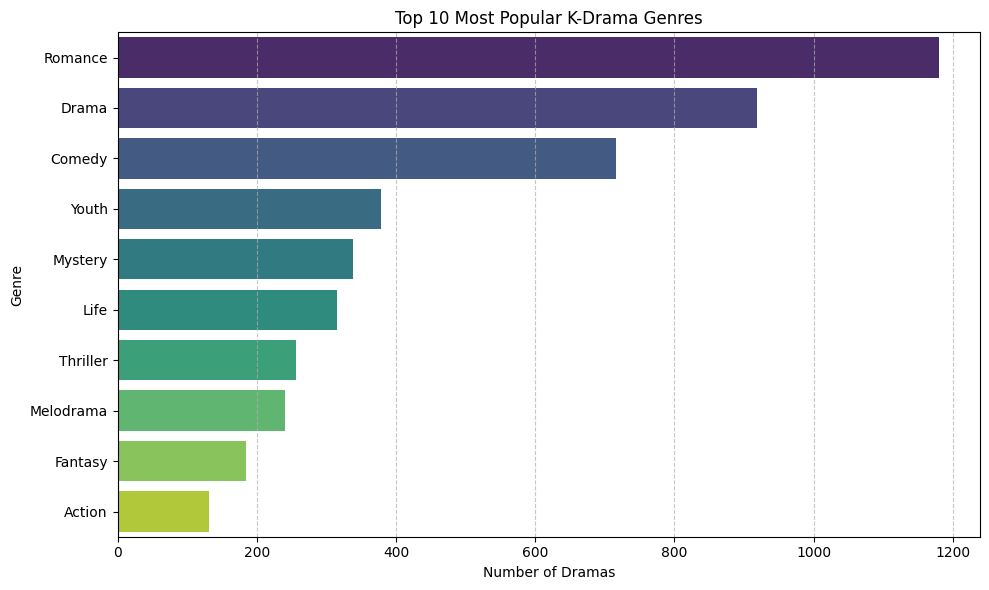

In [247]:
plt.figure(figsize=(10,6))
sns.barplot(x=top_genres.values, y=top_genres.index, palette="viridis")
plt.title('Top 10 Most Popular K-Drama Genres')
plt.xlabel('Number of Dramas')
plt.ylabel('Genre')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Visualisasi Plarform paling Populer

Visualisasi Genre paling banyak

In [252]:
platform_all = genres_df['where_to_watch'].dropna().str.split(', ')
all_platform_flat = [platform for sublist in platform_all for platform in sublist]

platform_counts = pd.Series(all_platform_flat).value_counts()
top_platform = platform_counts.head(10)

<ipython-input-255-7b91e8317293>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_platform.values, y=top_platform.index, palette="viridis")


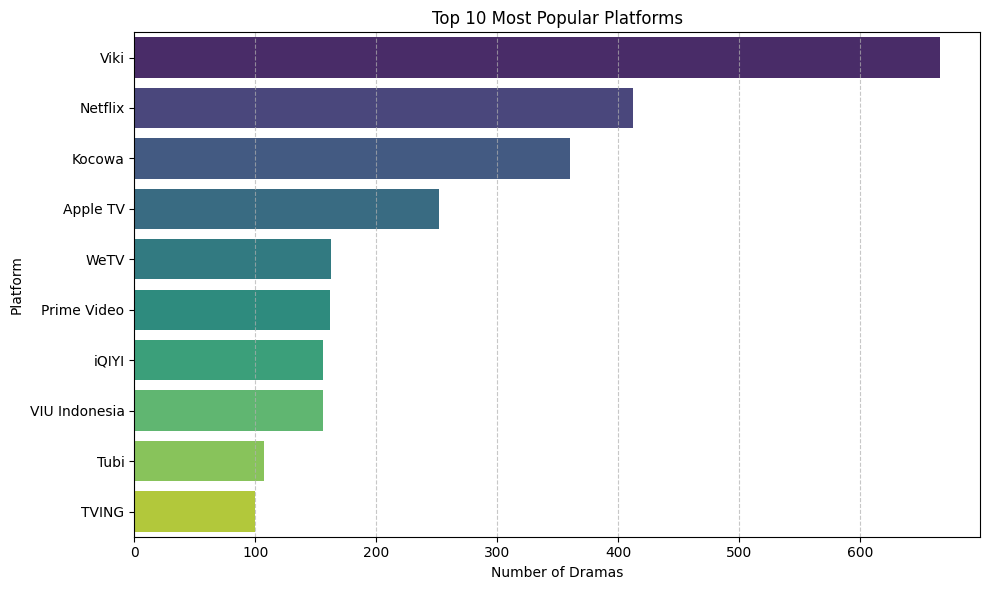

In [255]:
plt.figure(figsize=(10,6))
sns.barplot(x=top_platform.values, y=top_platform.index, palette="viridis")
plt.title('Top 10 Most Popular Platforms')
plt.xlabel('Number of Dramas')
plt.ylabel('Platform')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Data Preprocessing

## Mapping reviews_df

In [21]:
# Membuat mapping drama_name ke drama_id
mapping = dict(zip(kdrama_df['drama_name'].str.lower().str.strip(), kdrama_df['kdrama_id']))

# Membersihkan judul di reviews_df agar konsisten
reviews_df['title_clean'] = reviews_df['title'].str.lower().str.strip()

# Menambahkan kolom kdrama_id berdasarkan judul drama
reviews_df['kdrama_id'] = reviews_df['title_clean'].map(mapping)

In [22]:
# Cek Missing Judul ketika mapping
missing = reviews_df[reviews_df['kdrama_id'].isnull()]['title'].unique()
print("Judul drama yang tidak ditemukan di kdrama_df:", missing)

Judul drama yang tidak ditemukan di kdrama_df: []


In [23]:
cols = reviews_df.columns.tolist()
cols.remove('kdrama_id')
cols.remove('title_clean')

# Cari index kolom 'title'
idx = cols.index('title')
cols.insert(idx, 'kdrama_id')

# Reorder dataframe dengan urutan kolom baru
reviews_df = reviews_df[cols]

In [24]:
reviews_df.head()

,user_id,kdrama_id,title,story_score,acting_cast_score,music_score,rewatch_value_score,overall_score,review_text,ep_watched,n_helpful
0,c8ffdab3f2a338eeb54b265598dbbb55,661d4193916c4e71a2c70473ab11e9e8,Sing My Crush,9.0,9.0,10.0,9.0,9.0,the Best Song from my Crush This will now ran...,8 of 8 episodes seen,23
1,c8ffdab3f2a338eeb54b265598dbbb55,95b9396130b1478398d12faf08797097,Happy Merry Ending,5.0,7.0,9.0,4.0,6.5,I'm Happy and Merry That it Ended Quickly The ...,8 of 8 episodes seen,31
2,c8ffdab3f2a338eeb54b265598dbbb55,6b7782a36bfd47a4a787018ab0b3c5fb,Duty After School: Part 2,4.0,9.0,3.0,1.0,4.0,This PART 2 Should Never Have Happened If you...,4 of 4 episodes seen,121
3,c8ffdab3f2a338eeb54b265598dbbb55,f9860c4b65b746d7af2b545cd152a4b6,Our Dating Sim,9.0,9.5,9.0,9.0,9.0,I want to play this dating sim! I want to pla...,8 of 8 episodes seen,79
4,c8ffdab3f2a338eeb54b265598dbbb55,d6f2eb3a6fb7426587a69d9ea607ec68,The Director Who Buys Me Dinner,7.5,8.5,7.0,6.0,7.0,"Half-Cooked, Dont Eat A hard pass, unless som...",10 of 10 episodes seen,66


## Mapping genres_df

In [29]:
# Membersihkan kdrama_name di genres_df agar konsisten
genres_df['kdrama_name_clean'] = genres_df['title'].str.lower().str.strip()

# Menambahkan kolom kdrama_id berdasarkan judul drama
genres_df['kdrama_id'] = genres_df['kdrama_name_clean'].map(mapping)

In [30]:
# Cek Missing Judul ketika mapping
missing = genres_df[genres_df['kdrama_id'].isnull()]['title'].unique()
print("Judul drama yang tidak ditemukan di kdrama_df:", missing)

Judul drama yang tidak ditemukan di kdrama_df: ['The Uncanny Counter Season 2: Counter Punch' 'Twinkling Watermelon'
 'Moving' 'My Dearest' 'My Dearest Part 2' "Death's Game"
 'Daily Dose of Sunshine' 'The Kidnapping Day' 'The Worst of Evil'
 'The First Responders Season 2' 'Welcome to Samdal-ri' 'Vigilante'
 'Perfect Marriage Revenge' 'Boyhood' 'Tell Me That You Love Me'
 'Castaway Diva' 'Gyeongseong Creature' 'A Time Called You'
 'A Bloody Lucky Day' 'Super Junior: The Last Man Standing'
 'Arthdal Chronicles: The Sword of Aramun' 'My Demon'
 "The Story of Park's Marriage Contract" 'Song of the Bandits'
 'Like Flowers in Sand' 'Miraculous Brothers' 'My Lovely Liar'
 'Destined with You' 'Behind Your Touch' 'Night Has Come' 'Evilive'
 'A Breeze of Love' 'Maestra: Strings of Truth' 'True to Love'
 'Not Others' 'Korea-Khitan War' 'Persona: Sulli' 'The Killing Vote'
 'Sweet Home Season 2' 'Marry Me Now?' 'My Man Is Cupid' 'The Matchmakers'
 'My Lovely Boxer' 'Chip In' 'Kkondae Intern' 'The

In [31]:
cols = genres_df.columns.tolist()
cols.remove('kdrama_id')
cols.remove('kdrama_name_clean')

idx = cols.index('title')
cols.insert(idx, 'kdrama_id')

# Reorder dataframe dengan urutan kolom baru
genres_df = genres_df[cols]

In [32]:
genres_df

,kdrama_id,title,genres,where_to_watch
0,bf26febac8bb42d0ad491df290235451,Mad Dog,"Action, Thriller, Mystery","Apple TV, Netflix, Viki, Kocowa"
1,dd4c4da22cd144079c4e92ba4d587176,The Good Detective,"Action, Thriller, Mystery, Drama","Netflix, VIU Indonesia, Viki, Tubi"
2,247b9e25c4dc485b872874728c58de78,Crash Course in Romance,"Thriller, Mystery, Comedy, Romance",Netflix
3,7cc1983251ea4f3796ec6b54a12838bb,Amanza,"Adventure, Life, Fantasy, Melodrama","Kakao TV, Viki, Kocowa"
4,NaN,The Uncanny Counter Season 2: Counter Punch,"Action, Mystery, Comedy, Supernatural","TVING, Netflix"
...,...,...,...,...
1863,60312b4a037647e09ea87d370cd14d00,I'm Not a Loser,Drama,NaN
1864,ea2242d13ef44d548bef7a2652ff38ae,Sungkyunkwan Romance,"Romance, Youth",NaN
1865,5cee8b7b24a548fe8a8a19b367cb51fc,Summer Love,Romance,NaN
1866,94ac84b4410b48cb8b410f6d7d0ad2a1,Kkondae Intern,"Business, Comedy, Life, Drama","Netflix, WeTV, Viki, VIU Indonesia, Kocowa"


## Mengetahui Korean Drama Info

In [33]:
kdrama_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752 entries, 0 to 1751
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   kdrama_id     1752 non-null   object 
 1   drama_name    1752 non-null   object 
 2   year          1752 non-null   int64  
 3   director      1036 non-null   object 
 4   screenwriter  959 non-null    object 
 5   country       1752 non-null   object 
 6   type          1752 non-null   object 
 7   tot_eps       1752 non-null   int64  
 8   duration      1728 non-null   float64
 9   start_dt      1752 non-null   object 
 10  end_dt        1752 non-null   object 
 11  aired_on      1520 non-null   object 
 12  org_net       1344 non-null   object 
 13  content_rt    1752 non-null   object 
 14  synopsis      1584 non-null   object 
 15  rank          1752 non-null   int64  
 16  pop           1752 non-null   int64  
dtypes: float64(1), int64(4), object(12)
memory usage: 232.8+ KB


In [34]:
kdrama_info_df = kdrama_df[['kdrama_id', 'drama_name', 'year', 'tot_eps']]
kdrama_info_df

,kdrama_id,drama_name,year,tot_eps
0,661d4193916c4e71a2c70473ab11e9e8,Sing My Crush,2023,8
1,5ffcbeaa17114714af1959129984274c,D.P. Season 2,2023,6
2,65075cb9c1a54be4a441cee6f16c9fdf,Shadow Detective Season 2,2023,8
3,df0f0ac4b3ff4b15afa26f5a7a53a328,To Be Honest,2023,3
4,04c1fe41948e464fb440001831d74d41,Celebrity,2023,12
...,...,...,...,...
1747,e8c09f0f7d0d4b75a4642eb06d76d811,"Kill Me, Heal Me",2015,20
1748,1e7f7f2fa45d4240b8bb585ca13040f0,Enchanting Neighbor,2015,120
1749,142a09741fdd4daa878d6ae007201e43,Iron Lady Cha,2015,111
1750,9170c31a02014b56bb4cec2105086f00,The Family Is Coming,2015,20


## Mengetahui Genre

In [35]:
kdrama_genre_df = pd.merge(kdrama_df[['kdrama_id', 'drama_name']], genres_df[['kdrama_id', 'genres']], on='kdrama_id', how='left')
kdrama_genre_df

,kdrama_id,drama_name,genres
0,661d4193916c4e71a2c70473ab11e9e8,Sing My Crush,"Music, Comedy, Romance, Youth"
1,5ffcbeaa17114714af1959129984274c,D.P. Season 2,"Action, Military, Drama"
2,65075cb9c1a54be4a441cee6f16c9fdf,Shadow Detective Season 2,"Mystery, Drama"
3,df0f0ac4b3ff4b15afa26f5a7a53a328,To Be Honest,"Youth, Drama"
4,04c1fe41948e464fb440001831d74d41,Celebrity,"Thriller, Mystery, Drama"
...,...,...,...
1748,e8c09f0f7d0d4b75a4642eb06d76d811,"Kill Me, Heal Me","Psychological, Comedy, Romance, Drama"
1749,1e7f7f2fa45d4240b8bb585ca13040f0,Enchanting Neighbor,"Romance, Family, Melodrama"
1750,142a09741fdd4daa878d6ae007201e43,Iron Lady Cha,"Comedy, Romance, Drama, Family, Melodrama"
1751,9170c31a02014b56bb4cec2105086f00,The Family Is Coming,"Comedy, Romance, Family"


In [36]:
missing_genres = kdrama_genre_df[kdrama_genre_df['genres'].isna()]['drama_name'].unique()
print("Judul drama yang tidak ada genre:", missing_genres)

Judul drama yang tidak ada genre: ['Why Opposites Attract' 'The Escape Story of a Plastic Spoon' 'ShorTest'
 'The Price of a Life' 'Sweaty House' 'The [email\xa0protected]'
 'Happy Hostage' 'Crow Building']


In [37]:
print("Jumlah kdrama tanpa genre:", len(missing_genres))

Jumlah kdrama tanpa genre: 8


## Mengetahui Platforms Drama

In [38]:
kdrama_platform_df = pd.merge(
    kdrama_df[['kdrama_id', 'drama_name', 'org_net']],
    genres_df[['kdrama_id', 'where_to_watch']].rename(columns={'where_to_watch': 'platform'}),
    on='kdrama_id',
    how='left'
)

In [39]:
kdrama_platform_df['platform'] = kdrama_platform_df['platform'].fillna(kdrama_platform_df['org_net'])
kdrama_platform_df.drop(columns=['org_net'], inplace=True)

In [40]:
kdrama_platform_df

,kdrama_id,drama_name,platform
0,661d4193916c4e71a2c70473ab11e9e8,Sing My Crush,iQIYI
1,5ffcbeaa17114714af1959129984274c,D.P. Season 2,Netflix
2,65075cb9c1a54be4a441cee6f16c9fdf,Shadow Detective Season 2,"Disney+, Hulu"
3,df0f0ac4b3ff4b15afa26f5a7a53a328,To Be Honest,KOK TV
4,04c1fe41948e464fb440001831d74d41,Celebrity,Netflix
...,...,...,...
1748,e8c09f0f7d0d4b75a4642eb06d76d811,"Kill Me, Heal Me","Apple TV, Netflix, WeTV, Viki, China Huace TV,..."
1749,1e7f7f2fa45d4240b8bb585ca13040f0,Enchanting Neighbor,SBS
1750,142a09741fdd4daa878d6ae007201e43,Iron Lady Cha,MBC
1751,9170c31a02014b56bb4cec2105086f00,The Family Is Coming,"SBS World, Viki, Kocowa"


In [41]:
missing_ott = kdrama_platform_df[kdrama_platform_df['platform'].isna()]['drama_name'].unique()
print("Jumlah kdrama tanpa platform:", len(missing_ott))

Jumlah kdrama tanpa platform: 256


## Menggabung Data dengan fitur Judul Kdrama, Genre, dan Original Network

In [42]:
all_kdrama_rate_df = reviews_df[['user_id', 'kdrama_id', 'story_score', 'rewatch_value_score', 'overall_score']]
all_kdrama_rate_df.head()

,user_id,kdrama_id,story_score,rewatch_value_score,overall_score
0,c8ffdab3f2a338eeb54b265598dbbb55,661d4193916c4e71a2c70473ab11e9e8,9.0,9.0,9.0
1,c8ffdab3f2a338eeb54b265598dbbb55,95b9396130b1478398d12faf08797097,5.0,4.0,6.5
2,c8ffdab3f2a338eeb54b265598dbbb55,6b7782a36bfd47a4a787018ab0b3c5fb,4.0,1.0,4.0
3,c8ffdab3f2a338eeb54b265598dbbb55,f9860c4b65b746d7af2b545cd152a4b6,9.0,9.0,9.0
4,c8ffdab3f2a338eeb54b265598dbbb55,d6f2eb3a6fb7426587a69d9ea607ec68,7.5,6.0,7.0


In [43]:
all_kdrama_info_df = pd.merge(all_kdrama_rate_df, kdrama_info_df[['kdrama_id', 'drama_name', 'year', 'tot_eps']], on='kdrama_id', how='left')
all_kdrama_info_df.head()

,user_id,kdrama_id,story_score,rewatch_value_score,overall_score,drama_name,year,tot_eps
0,c8ffdab3f2a338eeb54b265598dbbb55,661d4193916c4e71a2c70473ab11e9e8,9.0,9.0,9.0,Sing My Crush,2023,8
1,c8ffdab3f2a338eeb54b265598dbbb55,95b9396130b1478398d12faf08797097,5.0,4.0,6.5,Happy Merry Ending,2023,8
2,c8ffdab3f2a338eeb54b265598dbbb55,6b7782a36bfd47a4a787018ab0b3c5fb,4.0,1.0,4.0,Duty After School: Part 2,2023,4
3,c8ffdab3f2a338eeb54b265598dbbb55,f9860c4b65b746d7af2b545cd152a4b6,9.0,9.0,9.0,Our Dating Sim,2023,8
4,c8ffdab3f2a338eeb54b265598dbbb55,d6f2eb3a6fb7426587a69d9ea607ec68,7.5,6.0,7.0,The Director Who Buys Me Dinner,2022,10


In [44]:
all_kdrama_name_df = pd.merge(all_kdrama_info_df, kdrama_genre_df[['kdrama_id', 'genres']], on='kdrama_id', how='left')
all_kdrama_name_df.head()

,user_id,kdrama_id,story_score,rewatch_value_score,overall_score,drama_name,year,tot_eps,genres
0,c8ffdab3f2a338eeb54b265598dbbb55,661d4193916c4e71a2c70473ab11e9e8,9.0,9.0,9.0,Sing My Crush,2023,8,"Music, Comedy, Romance, Youth"
1,c8ffdab3f2a338eeb54b265598dbbb55,95b9396130b1478398d12faf08797097,5.0,4.0,6.5,Happy Merry Ending,2023,8,"Romance, Drama"
2,c8ffdab3f2a338eeb54b265598dbbb55,6b7782a36bfd47a4a787018ab0b3c5fb,4.0,1.0,4.0,Duty After School: Part 2,2023,4,"Action, Thriller, Drama, Sci-Fi"
3,c8ffdab3f2a338eeb54b265598dbbb55,f9860c4b65b746d7af2b545cd152a4b6,9.0,9.0,9.0,Our Dating Sim,2023,8,"Business, Romance"
4,c8ffdab3f2a338eeb54b265598dbbb55,d6f2eb3a6fb7426587a69d9ea607ec68,7.5,6.0,7.0,The Director Who Buys Me Dinner,2022,10,"Romance, Fantasy"


In [45]:
all_kdrama_df = pd.merge(all_kdrama_name_df, kdrama_platform_df[['kdrama_id', 'platform']], on='kdrama_id', how='left')
all_kdrama_df.head()

,user_id,kdrama_id,story_score,rewatch_value_score,overall_score,drama_name,year,tot_eps,genres,platform
0,c8ffdab3f2a338eeb54b265598dbbb55,661d4193916c4e71a2c70473ab11e9e8,9.0,9.0,9.0,Sing My Crush,2023,8,"Music, Comedy, Romance, Youth",iQIYI
1,c8ffdab3f2a338eeb54b265598dbbb55,95b9396130b1478398d12faf08797097,5.0,4.0,6.5,Happy Merry Ending,2023,8,"Romance, Drama","Viki, Wavve, TVING"
2,c8ffdab3f2a338eeb54b265598dbbb55,6b7782a36bfd47a4a787018ab0b3c5fb,4.0,1.0,4.0,Duty After School: Part 2,2023,4,"Action, Thriller, Drama, Sci-Fi","Viki, VIU Indonesia"
3,c8ffdab3f2a338eeb54b265598dbbb55,f9860c4b65b746d7af2b545cd152a4b6,9.0,9.0,9.0,Our Dating Sim,2023,8,"Business, Romance",Viki
4,c8ffdab3f2a338eeb54b265598dbbb55,d6f2eb3a6fb7426587a69d9ea607ec68,7.5,6.0,7.0,The Director Who Buys Me Dinner,2022,10,"Romance, Fantasy","iQIYI, Wavve, TVING"


# Data Preparation

## Mengatasi Missing Value

In [46]:
all_kdrama_clean_df = all_kdrama_df.copy()

In [47]:
all_kdrama_clean_df.isnull().sum()

,0
user_id,0
kdrama_id,0
story_score,0
rewatch_value_score,0
overall_score,0
drama_name,0
year,0
tot_eps,0
genres,3
platform,233


Membersihkan missing value pada column genres dengan menghapusnya

In [48]:
all_kdrama_clean_df = all_kdrama_clean_df.dropna(subset=['genres'])

Mengisi data Nan pada coloum org_net dengan Not Available

In [49]:
all_kdrama_clean_df['platform'] = all_kdrama_clean_df['platform'].fillna('Not Available')

<ipython-input-49-a5186e7c4680>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_kdrama_clean_df['platform'] = all_kdrama_clean_df['platform'].fillna('Not Available')


Cek Kembali Missing Value

In [50]:
all_kdrama_clean_df.isna().sum()

,0
user_id,0
kdrama_id,0
story_score,0
rewatch_value_score,0
overall_score,0
drama_name,0
year,0
tot_eps,0
genres,0
platform,0


## Finishing

In [51]:
fix_kdrama_df = all_kdrama_clean_df.copy()
fix_kdrama_df.head()

,user_id,kdrama_id,story_score,rewatch_value_score,overall_score,drama_name,year,tot_eps,genres,platform
0,c8ffdab3f2a338eeb54b265598dbbb55,661d4193916c4e71a2c70473ab11e9e8,9.0,9.0,9.0,Sing My Crush,2023,8,"Music, Comedy, Romance, Youth",iQIYI
1,c8ffdab3f2a338eeb54b265598dbbb55,95b9396130b1478398d12faf08797097,5.0,4.0,6.5,Happy Merry Ending,2023,8,"Romance, Drama","Viki, Wavve, TVING"
2,c8ffdab3f2a338eeb54b265598dbbb55,6b7782a36bfd47a4a787018ab0b3c5fb,4.0,1.0,4.0,Duty After School: Part 2,2023,4,"Action, Thriller, Drama, Sci-Fi","Viki, VIU Indonesia"
3,c8ffdab3f2a338eeb54b265598dbbb55,f9860c4b65b746d7af2b545cd152a4b6,9.0,9.0,9.0,Our Dating Sim,2023,8,"Business, Romance",Viki
4,c8ffdab3f2a338eeb54b265598dbbb55,d6f2eb3a6fb7426587a69d9ea607ec68,7.5,6.0,7.0,The Director Who Buys Me Dinner,2022,10,"Romance, Fantasy","iQIYI, Wavve, TVING"


# **Model Development dengan Content-based Filtering**

## Filter Data yang Dibutuhkan

Mengambil data kdrama_id, drama_name, genres, dan platform

In [52]:
content_filter_df = fix_kdrama_df[['kdrama_id', 'drama_name', 'year', 'genres', 'platform', 'tot_eps']].copy()
content_filter_df

,kdrama_id,drama_name,year,genres,platform,tot_eps
0,661d4193916c4e71a2c70473ab11e9e8,Sing My Crush,2023,"Music, Comedy, Romance, Youth",iQIYI,8
1,95b9396130b1478398d12faf08797097,Happy Merry Ending,2023,"Romance, Drama","Viki, Wavve, TVING",8
2,6b7782a36bfd47a4a787018ab0b3c5fb,Duty After School: Part 2,2023,"Action, Thriller, Drama, Sci-Fi","Viki, VIU Indonesia",4
3,f9860c4b65b746d7af2b545cd152a4b6,Our Dating Sim,2023,"Business, Romance",Viki,8
4,d6f2eb3a6fb7426587a69d9ea607ec68,The Director Who Buys Me Dinner,2022,"Romance, Fantasy","iQIYI, Wavve, TVING",10
...,...,...,...,...,...,...
10620,98058140526d426eb878360903776f3d,Heart to Heart,2015,"Psychological, Comedy, Romance",tvN,16
10621,e8c09f0f7d0d4b75a4642eb06d76d811,"Kill Me, Heal Me",2015,"Psychological, Comedy, Romance, Drama","Apple TV, Netflix, WeTV, Viki, China Huace TV,...",20
10622,e8c09f0f7d0d4b75a4642eb06d76d811,"Kill Me, Heal Me",2015,"Psychological, Comedy, Romance, Drama","Apple TV, Netflix, WeTV, Viki, China Huace TV,...",20
10623,e8c09f0f7d0d4b75a4642eb06d76d811,"Kill Me, Heal Me",2015,"Psychological, Comedy, Romance, Drama","Apple TV, Netflix, WeTV, Viki, China Huace TV,...",20


Cek duplikasi data

In [53]:
dup_count = content_filter_df['kdrama_id'].duplicated().sum()
print('Jumlah data duplikat:', dup_count)

Jumlah data duplikat: 9345


Menghapus duplikasi data

In [54]:
content_filter_df = content_filter_df.drop_duplicates(subset='kdrama_id').copy()

## Text Normalization for Genres and Platforms

Karena tiap genre dan platform memiliki banyak values, maka perlu displit terlebih dahulu untuk dijadikan bentuk list

In [55]:
content_filter_df['genres'] = content_filter_df['genres'].str.split(',')
content_filter_df['platform'] = content_filter_df['platform'].str.split(',')

Merapikan spasi setelah split

In [56]:
content_filter_df['genres'] = content_filter_df['genres'].apply(
    lambda x: [i.strip() for i in x] if isinstance(x, list) else x
)

content_filter_df['platform'] = content_filter_df['platform'].apply(
    lambda x: [i.strip() for i in x] if isinstance(x, list) else x
)

Cek hasil split

In [57]:
print(content_filter_df['platform'].iloc[5])

['Viki', 'Prime Video', 'Netflix']


In [58]:
content_filter_df

,kdrama_id,drama_name,year,genres,platform,tot_eps
0,661d4193916c4e71a2c70473ab11e9e8,Sing My Crush,2023,"[Music, Comedy, Romance, Youth]",[iQIYI],8
1,95b9396130b1478398d12faf08797097,Happy Merry Ending,2023,"[Romance, Drama]","[Viki, Wavve, TVING]",8
2,6b7782a36bfd47a4a787018ab0b3c5fb,Duty After School: Part 2,2023,"[Action, Thriller, Drama, Sci-Fi]","[Viki, VIU Indonesia]",4
3,f9860c4b65b746d7af2b545cd152a4b6,Our Dating Sim,2023,"[Business, Romance]",[Viki],8
4,d6f2eb3a6fb7426587a69d9ea607ec68,The Director Who Buys Me Dinner,2022,"[Romance, Fantasy]","[iQIYI, Wavve, TVING]",10
...,...,...,...,...,...,...
10153,a1301f778dbd4aefb75392b78ffbc58b,Oh My God! Tip,2016,[Romance],[Naver TV Cast],4
10196,437da75ad9724193b21af661062fdb18,Virtual Excitement,2016,[Romance],[Not Available],6
10274,8b3cc6e1d4f9413782d4bb55184aad0e,Banana Actually,2015,"[Comedy, Romance, Life]","[AsianCrush, Tubi]",8
10427,8e0a1d23690d48e291a94ba5a40ff636,The Man in the Mask,2015,"[Action, Comedy, Romance, Drama]","[Viki, KBS World, Kocowa]",16


## Label Encoding

Melakukan label encoding untuk setiap genre dan platform pada dataset

In [59]:
mlb_genre = MultiLabelBinarizer()
genre_encoded = mlb_genre.fit_transform(content_filter_df['genres'])

Cek hasil encode dari genre

In [60]:
genre_encoded

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Cosine Similiarity

Menghitung cosine similiarity untuk genre

In [61]:
genre_similarity = cosine_similarity(genre_encoded)

In [62]:
print(genre_similarity)

[[1.         0.35355339 0.         ... 0.57735027 0.5        0.28867513]
 [0.35355339 1.         0.35355339 ... 0.40824829 0.70710678 0.40824829]
 [0.         0.35355339 1.         ... 0.         0.5        0.28867513]
 ...
 [0.57735027 0.40824829 0.         ... 1.         0.57735027 0.33333333]
 [0.5        0.70710678 0.5        ... 0.57735027 1.         0.57735027]
 [0.28867513 0.40824829 0.28867513 ... 0.33333333 0.57735027 1.        ]]


In [63]:
genre_sim_df = pd.DataFrame(genre_similarity, index=content_filter_df['drama_name'], columns=content_filter_df['drama_name'])
print('Shape:', genre_sim_df.shape)

Shape: (1277, 1277)


In [64]:
genre_sim_df.sample(10, axis=0).sample(5, axis=1)

drama_name,"I'm a Mother, Too",Re-Feel,He Is Psychometric,Soul Plate,Melancholia
drama_name,,,,,
Best Chicken,0.500000,0.500000,0.250000,0.353553,0.288675
V.I.P,0.750000,0.250000,0.500000,0.000000,0.577350
Diary of a Prosecutor,0.000000,0.250000,0.250000,0.000000,0.288675
Genome’s Romance,0.353553,0.707107,0.353553,0.000000,0.408248
Our Dating Sim,0.707107,0.353553,0.353553,0.000000,0.408248
Naughty Boy,0.353553,0.707107,0.353553,0.000000,0.408248
Hello Busking,0.250000,1.000000,0.250000,0.000000,0.577350
Uncle,0.000000,0.577350,0.000000,0.000000,0.333333
Things That May Occur to You Today,0.288675,0.866025,0.288675,0.000000,0.666667


Menggabungkan hasil encode genre dan platform

## Mendapatkan Rekomendasi

In [65]:
def genre_recommendations(drama_title, similarity_matrix, drama_info, top_k=5):
    """
    Rekomendasi drama berdasarkan kemiripan genre.

    Parameter:
    -----------
    drama_title : str
        Judul drama yang dijadikan acuan rekomendasi.
    similarity_matrix : pd.DataFrame
        Matriks kemiripan antar drama (index dan kolom adalah judul drama).
    drama_info : pd.DataFrame
        Dataframe yang berisi informasi drama (minimal kolom 'drama_name' dan info lain).
    top_k : int, default 5
        Jumlah rekomendasi yang diinginkan.

    Return:
    -----------
    pd.DataFrame
        Dataframe drama rekomendasi dengan informasi yang relevan.
    """

    if drama_title not in similarity_matrix.columns:
        raise ValueError(f"Drama '{drama_title}' tidak ditemukan di similarity matrix.")

    # Ambil similarity scores drama yang ditentukan
    sim_scores = similarity_matrix[drama_title]

    # Ambil top_k+1 terbesar (salah satunya pasti drama itu sendiri)
    closest = sim_scores.nlargest(top_k+1).index.drop(drama_title, errors='ignore')[:top_k]

    # Filter drama_info yang termasuk dalam rekomendasi
    recommendations = drama_info[drama_info['drama_name'].isin(closest)].reset_index(drop=True)

    return recommendations

In [66]:
drama_name_key = 'The Devil Judge'
drama_total = 10

In [67]:
drama_name_key = input('Masukkan Nama Drama: ')
drama_total = int(input('Masukkan Jumlah Rekomendasi Drama: '))

Masukkan Nama Drama: The Devil Judge
Masukkan Jumlah Rekomendasi Drama: 10


In [68]:
content_filter_df[content_filter_df['drama_name'].eq(drama_name_key)]

,kdrama_id,drama_name,year,genres,platform,tot_eps
1968,22dca69dbdb74efa9566fa28551fbf5e,The Devil Judge,2021,"[Mystery, Law, Crime, Drama]","[Netflix, WeTV, Viki, iQIYI, TVING, VIU Indone...",16


In [69]:
genre_recommendations(drama_name_key, genre_sim_df, content_filter_df, top_k=drama_total)

,kdrama_id,drama_name,year,genres,platform,tot_eps
0,49846934ef8d4b719668046fe9b1b2a9,Big Mouth,2022,"[Thriller, Mystery, Law, Drama]","[Apple TV, Disney+ Hotstar, Disney+, Wavve, Hulu]",16
1,9d36063c5c4c43f88286381e3da0c2e0,Decoy: Part 1,2023,"[Thriller, Mystery, Crime, Drama]","[Viki, Prime Video]",6
2,b965d67bd58542718fbabb6c80fb3877,She Knows Everything,2020,"[Mystery, Psychological, Crime, Drama]","[Viki, Kocowa]",4
3,3abde6bdc0c84a50a63bb75aec86c4b7,Justice,2019,"[Thriller, Mystery, Law, Drama]","[Apple TV, Viki, KBS World, Kocowa]",32
4,dccdc72a8f634dcb852888d5a56ded83,Shadow Detective,2022,"[Mystery, Crime, Drama]","[Disney+ Hotstar, Disney+, Hulu]",8
5,afce304dbfa1470dbde67f249b77e292,May It Please the Court,2022,"[Mystery, Law, Drama]","[Disney+ Hotstar, Disney+, Hulu]",12
6,c441f51e62ba4aceaed6fbe0e95629ad,Witch's Court,2017,"[Mystery, Law, Drama]","[Apple TV, Netflix, KBS World, Kocowa]",16
7,71a36358fd704b80b56042110f60a2f8,Law School,2021,"[Mystery, Law, Crime, Drama]",[Netflix],16
8,fc4b5627d917413b8d1f34b06b0f68de,The Running Mates: Human Rights,2019,"[Mystery, Law, Drama]",[Viki],14
9,36695acdb8494650a0460b2f9db5b0c7,Justice Team,2016,"[Mystery, Law, Drama]",[Naver TV Cast],4


In [70]:
def platform_filter_recommendations(drama_title, platform_choice, drama_info, similarity_matrix, top_k=drama_total):
    """
    Cari rekomendasi genre dulu, lalu filter hasil rekomendasi itu berdasarkan platform_choice.

    Param:
    - drama_title: str, judul drama input
    - platform_choice: str, platform yang ingin difilter (misal 'VIU')
    - drama_info: DataFrame, info drama dengan kolom 'drama_name', 'platform', dll.
    - similarity_matrix: matrix similarity genre (dipakai di genre_recommendations)
    - top_k: int, jumlah rekomendasi

    Return:
    - DataFrame rekomendasi drama sesuai genre dan platform
    """

    # Dapatkan rekomendasi berdasarkan genre
    genre_recs = genre_recommendations(drama_title, similarity_matrix, drama_info, top_k=drama_total)

    # Filter berdasarkan platform
    filtered_recs = genre_recs[genre_recs['platform'].apply(lambda x: platform_choice in x)]

    # Ambil maksimal top_k setelah filter platform
    filtered_recs = filtered_recs.head(top_k)

    if filtered_recs.empty:
        return f"Tidak ada rekomendasi drama di platform '{platform_choice}' berdasarkan genre drama '{drama_title}'."

    return filtered_recs.reset_index(drop=True)

In [71]:
platform_key = 'Viki'

In [72]:
platform_key = input('Masukkan Platform: ')

Masukkan Platform: Disney +


In [73]:
platform_rekom = platform_filter_recommendations(drama_name_key, platform_key, content_filter_df, genre_sim_df)
platform_rekom

"Tidak ada rekomendasi drama di platform 'Disney +' berdasarkan genre drama 'The Devil Judge'."

# **Model Development dengan Collaborative Filtering**

In [123]:
collaborative_filter_df = fix_kdrama_df[['user_id', 'kdrama_id', 'story_score', 'rewatch_value_score', 'overall_score']].copy()
collaborative_filter_df

,user_id,kdrama_id,story_score,rewatch_value_score,overall_score
0,c8ffdab3f2a338eeb54b265598dbbb55,661d4193916c4e71a2c70473ab11e9e8,9.0,9.0,9.0
1,c8ffdab3f2a338eeb54b265598dbbb55,95b9396130b1478398d12faf08797097,5.0,4.0,6.5
2,c8ffdab3f2a338eeb54b265598dbbb55,6b7782a36bfd47a4a787018ab0b3c5fb,4.0,1.0,4.0
3,c8ffdab3f2a338eeb54b265598dbbb55,f9860c4b65b746d7af2b545cd152a4b6,9.0,9.0,9.0
4,c8ffdab3f2a338eeb54b265598dbbb55,d6f2eb3a6fb7426587a69d9ea607ec68,7.5,6.0,7.0
...,...,...,...,...,...
10620,33bb7ae6e00a345c927f1b8e39594908,98058140526d426eb878360903776f3d,8.0,9.0,9.0
10621,e5d4bbe315b03eb4878aa84d2f4fcff0,e8c09f0f7d0d4b75a4642eb06d76d811,8.5,10.0,9.5
10622,43aaace8631f36eda17a1880c7329a82,e8c09f0f7d0d4b75a4642eb06d76d811,5.5,5.5,5.5
10623,172b38a4599f3a649fe192fb967ce084,e8c09f0f7d0d4b75a4642eb06d76d811,9.0,8.0,9.5


In [128]:
coll_kdrama_filter_df = pd.merge(kdrama_info_df, kdrama_genre_df[['kdrama_id', 'genres']], on='kdrama_id', how='left')
coll_kdrama_filter_df = coll_kdrama_filter_df.dropna(subset=['genres'])
coll_kdrama_filter_df

,kdrama_id,drama_name,year,tot_eps,genres
0,661d4193916c4e71a2c70473ab11e9e8,Sing My Crush,2023,8,"Music, Comedy, Romance, Youth"
1,5ffcbeaa17114714af1959129984274c,D.P. Season 2,2023,6,"Action, Military, Drama"
2,65075cb9c1a54be4a441cee6f16c9fdf,Shadow Detective Season 2,2023,8,"Mystery, Drama"
3,df0f0ac4b3ff4b15afa26f5a7a53a328,To Be Honest,2023,3,"Youth, Drama"
4,04c1fe41948e464fb440001831d74d41,Celebrity,2023,12,"Thriller, Mystery, Drama"
...,...,...,...,...,...
1747,98058140526d426eb878360903776f3d,Heart to Heart,2015,16,"Psychological, Comedy, Romance"
1748,e8c09f0f7d0d4b75a4642eb06d76d811,"Kill Me, Heal Me",2015,20,"Psychological, Comedy, Romance, Drama"
1749,1e7f7f2fa45d4240b8bb585ca13040f0,Enchanting Neighbor,2015,120,"Romance, Family, Melodrama"
1750,142a09741fdd4daa878d6ae007201e43,Iron Lady Cha,2015,111,"Comedy, Romance, Drama, Family, Melodrama"


## user_id

Mengubah user_id menjadi list tanpa nilai yang sama

In [75]:
user_ids = collaborative_filter_df['user_id'].unique().tolist()
print('List user id: ', user_ids)

List user id:  ['c8ffdab3f2a338eeb54b265598dbbb55', '01b015525e8f34ba9e776af1dadc7610', '02daa3d8e7eb36b3b3a2dec5fc4eb9cd', '1c8bbd8058fd3e719def4cc3746ffd59', 'b1c75f6a89893578b904b21d3612a036', '5a66c5f1a2b23c9e905e91c2d328015a', 'cb8ef7667add3299bade908f708b36a2', '99c183eb5b9435119b7a5ff2f5164941', '2dd2ff45ac40396fa3a82f935fb72593', '4957f97b45bd3329a2e8428a3a2d31e7', 'ef2ab82895583156914ff3980525a01c', '1f5a2b2c5896306aa6375257b0d0d887', '5b94afef16f53ae1a277a35f148727f7', 'a738d2c7283a38309b4cf97629990296', '7a38b70ac6ce3530843cf86fa1520b21', '201994e537753654818be8c25cee5ad4', 'b2c381f809ee37a4a59888832213bd65', '19e190dc616d3696bf19019955a2f272', '602578cd61653deba845b40799ea7df9', '1933258ee8783e02aa231a423d884268', '4297266302c53cb1813b38211e6490c4', '8c3d2946f44e34eeba4c135731045839', 'ff53c06a28ea37cc8e36d8a29af65af9', '5b2c202af84130d0aac1a0b525d4c35f', 'ae0450a485073607855652ba7215911d', 'f04b2b96640e3374b738db6d15880e30', '5114de62a4aa3e3fbd3df4368841a30e', '832b9d0965e

Melakukan encoding user_id atau mengubah bentuk string dari user_id menjadi angka

In [76]:
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('encoded user_id : ', user_to_user_encoded)

encoded user_id :  {'c8ffdab3f2a338eeb54b265598dbbb55': 0, '01b015525e8f34ba9e776af1dadc7610': 1, '02daa3d8e7eb36b3b3a2dec5fc4eb9cd': 2, '1c8bbd8058fd3e719def4cc3746ffd59': 3, 'b1c75f6a89893578b904b21d3612a036': 4, '5a66c5f1a2b23c9e905e91c2d328015a': 5, 'cb8ef7667add3299bade908f708b36a2': 6, '99c183eb5b9435119b7a5ff2f5164941': 7, '2dd2ff45ac40396fa3a82f935fb72593': 8, '4957f97b45bd3329a2e8428a3a2d31e7': 9, 'ef2ab82895583156914ff3980525a01c': 10, '1f5a2b2c5896306aa6375257b0d0d887': 11, '5b94afef16f53ae1a277a35f148727f7': 12, 'a738d2c7283a38309b4cf97629990296': 13, '7a38b70ac6ce3530843cf86fa1520b21': 14, '201994e537753654818be8c25cee5ad4': 15, 'b2c381f809ee37a4a59888832213bd65': 16, '19e190dc616d3696bf19019955a2f272': 17, '602578cd61653deba845b40799ea7df9': 18, '1933258ee8783e02aa231a423d884268': 19, '4297266302c53cb1813b38211e6490c4': 20, '8c3d2946f44e34eeba4c135731045839': 21, 'ff53c06a28ea37cc8e36d8a29af65af9': 22, '5b2c202af84130d0aac1a0b525d4c35f': 23, 'ae0450a485073607855652ba72159

Melakukan encoding angka ke user_id atau mengubah kembali dari bentuk angka ke id asli

In [77]:
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('encoded angka ke userID: ', user_encoded_to_user)

encoded angka ke userID:  {0: 'c8ffdab3f2a338eeb54b265598dbbb55', 1: '01b015525e8f34ba9e776af1dadc7610', 2: '02daa3d8e7eb36b3b3a2dec5fc4eb9cd', 3: '1c8bbd8058fd3e719def4cc3746ffd59', 4: 'b1c75f6a89893578b904b21d3612a036', 5: '5a66c5f1a2b23c9e905e91c2d328015a', 6: 'cb8ef7667add3299bade908f708b36a2', 7: '99c183eb5b9435119b7a5ff2f5164941', 8: '2dd2ff45ac40396fa3a82f935fb72593', 9: '4957f97b45bd3329a2e8428a3a2d31e7', 10: 'ef2ab82895583156914ff3980525a01c', 11: '1f5a2b2c5896306aa6375257b0d0d887', 12: '5b94afef16f53ae1a277a35f148727f7', 13: 'a738d2c7283a38309b4cf97629990296', 14: '7a38b70ac6ce3530843cf86fa1520b21', 15: '201994e537753654818be8c25cee5ad4', 16: 'b2c381f809ee37a4a59888832213bd65', 17: '19e190dc616d3696bf19019955a2f272', 18: '602578cd61653deba845b40799ea7df9', 19: '1933258ee8783e02aa231a423d884268', 20: '4297266302c53cb1813b38211e6490c4', 21: '8c3d2946f44e34eeba4c135731045839', 22: 'ff53c06a28ea37cc8e36d8a29af65af9', 23: '5b2c202af84130d0aac1a0b525d4c35f', 24: 'ae0450a48507360785

Mapping user_id ke dataframe user

In [78]:
collaborative_filter_df['user'] = collaborative_filter_df['user_id'].map(user_to_user_encoded)

Mengetahui jumlah user

In [84]:
num_users = len(user_to_user_encoded)
print(num_users)

4562


## kdrama_id

Mengubah kdrama_ids menjadi list tanpa nilai yang sama

In [79]:
kdrama_ids = collaborative_filter_df['kdrama_id'].unique().tolist()
print('List drama id: ', kdrama_ids)

List drama id:  ['661d4193916c4e71a2c70473ab11e9e8', '95b9396130b1478398d12faf08797097', '6b7782a36bfd47a4a787018ab0b3c5fb', 'f9860c4b65b746d7af2b545cd152a4b6', 'd6f2eb3a6fb7426587a69d9ea607ec68', '9f18660af3e84496b65832d2e8b36c5b', '1c135017a2ca403fb696b333753a71e1', '38bed0dcd0644ee897ef84d587aabd78', '49846934ef8d4b719668046fe9b1b2a9', '7edb2a10033f41a89fc05a1dc564698a', 'd2e509b0293549bab62b76a9f8630956', 'ec80f88a2e594a909facc164a0d73363', '4ca05130abbe465e9977b7f163968e0f', 'fa66edaa18174140a493953f362adb82', 'bff00514de05407aadfe5e46df7e6ee5', '52225793342e440d90354d4a0f305586', '8057ee35785644d5b7b09042e559776e', '62cf5f2690c54981a959fdfa618605ab', 'ddc829b4c170484d94efedfb4cb29f3d', 'b27d22a8e87b4749a532a276d1b3d196', '3207a7aab81a42d49d024ef616f4d254', '49f2d0c965754bddb0da5f1b26a2ceb0', 'c8e2ead5aba445e7a4c501c77dc4272c', '78ff11b4301b4694a73b510e34a5d03d', '47b65449450d478c96e0612571583cdf', '84f5fe50666c49a7b6f06f000cf9d25f', '13e0534998514029bd39c66254b65035', '345d9671f9

Melakukan encoding kdrama_ids atau mengubah bentuk string dari kdrama_id menjadi angka

In [80]:
kdrama_to_kdrama_encoded = {x: i for i, x in enumerate(kdrama_ids)}
print('encoded angka ke kdrama_id: ', kdrama_to_kdrama_encoded)

encoded angka ke kdrama_id:  {'661d4193916c4e71a2c70473ab11e9e8': 0, '95b9396130b1478398d12faf08797097': 1, '6b7782a36bfd47a4a787018ab0b3c5fb': 2, 'f9860c4b65b746d7af2b545cd152a4b6': 3, 'd6f2eb3a6fb7426587a69d9ea607ec68': 4, '9f18660af3e84496b65832d2e8b36c5b': 5, '1c135017a2ca403fb696b333753a71e1': 6, '38bed0dcd0644ee897ef84d587aabd78': 7, '49846934ef8d4b719668046fe9b1b2a9': 8, '7edb2a10033f41a89fc05a1dc564698a': 9, 'd2e509b0293549bab62b76a9f8630956': 10, 'ec80f88a2e594a909facc164a0d73363': 11, '4ca05130abbe465e9977b7f163968e0f': 12, 'fa66edaa18174140a493953f362adb82': 13, 'bff00514de05407aadfe5e46df7e6ee5': 14, '52225793342e440d90354d4a0f305586': 15, '8057ee35785644d5b7b09042e559776e': 16, '62cf5f2690c54981a959fdfa618605ab': 17, 'ddc829b4c170484d94efedfb4cb29f3d': 18, 'b27d22a8e87b4749a532a276d1b3d196': 19, '3207a7aab81a42d49d024ef616f4d254': 20, '49f2d0c965754bddb0da5f1b26a2ceb0': 21, 'c8e2ead5aba445e7a4c501c77dc4272c': 22, '78ff11b4301b4694a73b510e34a5d03d': 23, '47b65449450d478c96e

Melakukan encoding angka ke kdrama_ids atau mengubah kembali dari bentuk angka ke id asli

In [81]:
kdrama_encoded_to_kdrama = {i: x for i, x in enumerate(kdrama_ids)}
print('encoded angka ke kdrama_id: ', kdrama_encoded_to_kdrama)

encoded angka ke kdrama_id:  {0: '661d4193916c4e71a2c70473ab11e9e8', 1: '95b9396130b1478398d12faf08797097', 2: '6b7782a36bfd47a4a787018ab0b3c5fb', 3: 'f9860c4b65b746d7af2b545cd152a4b6', 4: 'd6f2eb3a6fb7426587a69d9ea607ec68', 5: '9f18660af3e84496b65832d2e8b36c5b', 6: '1c135017a2ca403fb696b333753a71e1', 7: '38bed0dcd0644ee897ef84d587aabd78', 8: '49846934ef8d4b719668046fe9b1b2a9', 9: '7edb2a10033f41a89fc05a1dc564698a', 10: 'd2e509b0293549bab62b76a9f8630956', 11: 'ec80f88a2e594a909facc164a0d73363', 12: '4ca05130abbe465e9977b7f163968e0f', 13: 'fa66edaa18174140a493953f362adb82', 14: 'bff00514de05407aadfe5e46df7e6ee5', 15: '52225793342e440d90354d4a0f305586', 16: '8057ee35785644d5b7b09042e559776e', 17: '62cf5f2690c54981a959fdfa618605ab', 18: 'ddc829b4c170484d94efedfb4cb29f3d', 19: 'b27d22a8e87b4749a532a276d1b3d196', 20: '3207a7aab81a42d49d024ef616f4d254', 21: '49f2d0c965754bddb0da5f1b26a2ceb0', 22: 'c8e2ead5aba445e7a4c501c77dc4272c', 23: '78ff11b4301b4694a73b510e34a5d03d', 24: '47b65449450d478

Mapping kdrama_id ke dataframe kdrama

In [82]:
collaborative_filter_df['kdrama'] = collaborative_filter_df['kdrama_id'].map(kdrama_to_kdrama_encoded)

In [83]:
collaborative_filter_df

,user_id,kdrama_id,story_score,rewatch_value_score,overall_score,user,kdrama
0,c8ffdab3f2a338eeb54b265598dbbb55,661d4193916c4e71a2c70473ab11e9e8,9.0,9.0,9.0,0,0
1,c8ffdab3f2a338eeb54b265598dbbb55,95b9396130b1478398d12faf08797097,5.0,4.0,6.5,0,1
2,c8ffdab3f2a338eeb54b265598dbbb55,6b7782a36bfd47a4a787018ab0b3c5fb,4.0,1.0,4.0,0,2
3,c8ffdab3f2a338eeb54b265598dbbb55,f9860c4b65b746d7af2b545cd152a4b6,9.0,9.0,9.0,0,3
4,c8ffdab3f2a338eeb54b265598dbbb55,d6f2eb3a6fb7426587a69d9ea607ec68,7.5,6.0,7.0,0,4
...,...,...,...,...,...,...,...
10620,33bb7ae6e00a345c927f1b8e39594908,98058140526d426eb878360903776f3d,8.0,9.0,9.0,4557,855
10621,e5d4bbe315b03eb4878aa84d2f4fcff0,e8c09f0f7d0d4b75a4642eb06d76d811,8.5,10.0,9.5,4558,448
10622,43aaace8631f36eda17a1880c7329a82,e8c09f0f7d0d4b75a4642eb06d76d811,5.5,5.5,5.5,4559,448
10623,172b38a4599f3a649fe192fb967ce084,e8c09f0f7d0d4b75a4642eb06d76d811,9.0,8.0,9.5,4560,448


Mengetahui jumlah kdrama

In [85]:
num_kdrama = len(kdrama_to_kdrama_encoded)
print(num_kdrama)

1277


## overall_score

Mengubah nilai overall_score menjadi nilai float

In [87]:
collaborative_filter_df['overall_score'] = collaborative_filter_df['overall_score'].values.astype(np.float32)

Mengetahui nilai minimum overall_score

In [88]:
min_overall_score = min(collaborative_filter_df['overall_score'])

Mengetahui nilai maksimum overall_score

In [89]:
max_overall_score = max(collaborative_filter_df['overall_score'])

In [90]:
print('Min Rating: {}, Max Rating: {}'.format(
    min_overall_score, max_overall_score
))

Min Rating: 1.0, Max Rating: 10.0


## Membagi Data untuk Training dan Validasi

Mengacak dataset

In [92]:
collaborative_filter_df = collaborative_filter_df.sample(frac=1, random_state=42)
collaborative_filter_df

,user_id,kdrama_id,story_score,rewatch_value_score,overall_score,user,kdrama
7432,1d3c2e05f8853978b747bb9459deffca,ebff4229dd49477f9e9ca4a28829b1b6,7.0,6.0,7.0,2520,720
1741,123a3d23ec433723acaf8d5691a2ad7f,9cfc95bb5cc24d9da3d9f3d3c9eb1ce5,6.0,6.0,6.0,232,570
2337,d456381e582534d7a757f155bf6f0dd9,27a3c07fbcac45c29a6c5f0daac89eda,7.5,4.5,7.5,362,901
5795,57eb08818e853799972065b4f4c6bc70,9a21086848a34fec85f76e1b27fdfc1a,9.5,8.0,9.0,1692,357
5178,10f7f888d4d63322919fc305a59644a4,3e91c046938c455aba649dc01e322f68,9.0,9.5,9.5,1411,182
...,...,...,...,...,...,...,...
5709,688644ec39c63c12a30e43e1c479adf4,bdc12e94c79246f89a142e0040a7fcec,6.0,6.0,6.0,1669,477
6395,9d898e7211a53d5a98889e9b426a075d,8b05b83d261e4729b0aed950a79a54e3,7.0,1.0,6.5,2009,373
5817,bc5639eee1093784bc459edf1862b741,8513adcd3d6848b796db14fe5a79d1a4,9.5,8.0,9.5,1700,876
10181,d169266159533f398335e699f065a7ce,9cfa2669b51147d1b48908e94fb93d8c,8.0,8.5,9.5,4201,1238


Selanjutnya, kita bagi data train dan validasi dengan komposisi 80:20. Namun sebelumnya, kita perlu memetakan (mapping) data user dan resto menjadi satu value terlebih dahulu. Lalu, buatlah rating dalam skala 0 sampai 1 agar mudah dalam melakukan proses training.

Membuat variabel x untuk mencocokkan data user dan resto menjadi satu value

In [93]:
x = collaborative_filter_df[['user', 'kdrama']].values

Membuat variabel y untuk membuat overall_score dari hasil dengan min max scaling sehingga score berada di range 0 - 1

In [94]:
y = collaborative_filter_df['overall_score'].apply(lambda x: (x - min_overall_score) / (max_overall_score - min_overall_score)).values

Membagi menjadi 80% data train dan 20% data validasi

In [95]:
train_indices = int(0.8 * collaborative_filter_df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[2520  720]
 [ 232  570]
 [ 362  901]
 ...
 [1700  876]
 [4201 1238]
 [4090  283]] [0.66666667 0.55555556 0.72222222 ... 0.94444444 0.94444444 1.        ]


## Proses Training

Pada tahap ini, model menghitung skor kecocokan antara pengguna dan korean drama dengan teknik embedding. Pertama, kita melakukan proses embedding terhadap data user dan kdrama. Selanjutnya, lakukan operasi perkalian dot product antara embedding user dan kdrama. Selain itu, kita juga dapat menambahkan bias untuk setiap user dan kdrama. Skor kecocokan ditetapkan dalam skala [0,1] dengan fungsi aktivasi sigmoid.

In [227]:
class RecommenderNet(tf.keras.Model):

  # Insialisasi fungsi
  def __init__(self, num_users, num_kdrama, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_kdrama = num_kdrama
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.kdrama_embedding = layers.Embedding( # layer embeddings kdrama
        num_kdrama,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.kdrama_bias = layers.Embedding(num_kdrama, 1) # layer embedding kdrama bias
    self.dense = layers.Dense(1, activation='sigmoid')

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    kdrama_vector = self.kdrama_embedding(inputs[:, 1]) # memanggil layer embedding 3
    kdrama_bias = self.kdrama_bias(inputs[:, 1]) # memanggil layer embedding 4

    # dot_user_kdrama = tf.tensordot(user_vector, kdrama_vector, 2)
    dot_user_kdrama = tf.reduce_sum(user_vector * kdrama_vector, axis=1, keepdims=True)

    x = dot_user_kdrama + user_bias + kdrama_bias
    x = self.dense(x)

    return tf.nn.sigmoid(x) # activation sigmoid

In [232]:
model = RecommenderNet(num_users, num_kdrama, 64) # inisialisasi model

model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [233]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5,
    min_lr=1e-6, verbose=1
)

Memulai training

In [234]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val),
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 69s 7ms/step - loss: 0.0672 - root_mean_squared_error: 0.2588 - val_loss: 0.0685 - val_root_mean_squared_error: 0.2614 - learning_rate: 1.0000e-04
Epoch 2/100
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0671 - root_mean_squared_error: 0.2586 - val_loss: 0.0672 - val_root_mean_squared_error: 0.2590 - learning_rate: 1.0000e-04
Epoch 3/100
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0649 - root_mean_squared_error: 0.2544 - val_loss: 0.0661 - val_root_mean_squared_error: 0.2568 - learning_rate: 1.0000e-04
Epoch 4/100
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0644 - root_mean_squared_error: 0.2533 - val_loss: 0.0650 - val_root_mean_squared_error: 0.2546 - learning_rate: 1.0000e-04
Epoch 5/100
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0618 - root_mean_squared_error: 0.2482 - val_loss: 0.0640 - val_root_mean_squared_error: 0.2526 - learning_rate: 1.0000e-04
Epoch 6/100
1063/1063 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/st

Prediksi dari model

In [245]:
y_pred = model.predict(x_val).flatten()

# RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE: {rmse:.4f}")

# MAE
mae = mean_absolute_error(y_val, y_pred)
print(f"MAE: {mae:.4f}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE: 0.2217
MAE: 0.1817


## Visualisasi Metrik

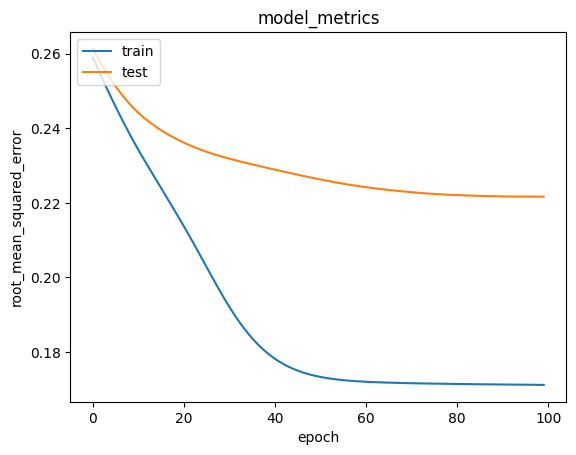

In [231]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Mendapatkan Rekomendasi

In [235]:
final_kdrama_df = coll_kdrama_filter_df
score_kdrama_df = all_kdrama_rate_df.copy()

# Mengambil sample user
user_ids = score_kdrama_df.user_id.sample(1).iloc[0]
kdrama_watched_by_user = score_kdrama_df[score_kdrama_df.user_id == user_ids]

# Operator bitwise (~), bisa diketahui di sini https://docs.python.org/3/reference/expressions.html
kdrama_not_watched = final_kdrama_df[~final_kdrama_df['kdrama_id'].isin(kdrama_watched_by_user.kdrama_id.values)]['kdrama_id']
kdrama_not_watched = list(
    set(kdrama_not_watched)
    .intersection(set(kdrama_to_kdrama_encoded.keys()))
)

kdrama_not_watched = [[kdrama_to_kdrama_encoded.get(x)] for x in kdrama_not_watched]
user_encoder = user_to_user_encoded.get(user_ids)
user_kdrama_array = np.hstack(
    ([[user_encoder]] * len(kdrama_not_watched), kdrama_not_watched)
)

In [236]:
def print_kdrama_recommendation(df):
    if df.empty:
        print("Tidak ada rekomendasi untuk ditampilkan.")
        return

    table = []
    for i, row in enumerate(df.itertuples(), 1):
        table.append([i, row.drama_name, row.year, row.tot_eps, row.genres])

    headers = ["#", "Judul", "Tahun", "Episode", "Genre"]
    print(tabulate(table, headers=headers, tablefmt="fancy_grid"))

In [237]:
scores = model.predict(user_kdrama_array).flatten()

top_scores_indices = scores.argsort()[-10:][::-1]
recommended_kdrama_ids = [
    kdrama_encoded_to_kdrama.get(kdrama_not_watched[x][0]) for x in top_scores_indices
]

print('Showing recommendations for users: {}'.format(user_ids))
print('\nKdrama with high scores from user')

top_kdrama_user = (
    kdrama_watched_by_user.sort_values(
        by = 'overall_score',
        ascending=False
    )
    .head(5)
    .kdrama_id.values
)

kdrama_df_rows = final_kdrama_df[final_kdrama_df['kdrama_id'].isin(top_kdrama_user)]
print_kdrama_recommendation(kdrama_df_rows)

print('\nTop 10 kdrama recommendation')

recommended_kdrama = final_kdrama_df[final_kdrama_df['kdrama_id'].isin(recommended_kdrama_ids)]
print_kdrama_recommendation(recommended_kdrama)

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Showing recommendations for users: 55ef1033f90b39d19c265fe43109bfbe

Kdrama with high scores from user
╒═════╤════════════════════════════╤═════════╤═══════════╤════════════════════════════════════╕
│   # │ Judul                      │   Tahun │   Episode │ Genre                              │
╞═════╪════════════════════════════╪═════════╪═══════════╪════════════════════════════════════╡
│   1 │ Extraordinary Attorney Woo │    2022 │        16 │ Law, Romance, Life, Drama          │
├─────┼────────────────────────────┼─────────┼───────────┼────────────────────────────────────┤
│   2 │ To.Two                     │    2021 │         8 │ Thriller, Psychological, Youth     │
├─────┼────────────────────────────┼─────────┼───────────┼────────────────────────────────────┤
│   3 │ Back to the 2008           │    2021 │        10 │ Romance, Youth                     │
├─────┼────────────────────────────┼─────────┼───────────┼────────────────────────────────